<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW3/HW3_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged after 21 iterations.

TRUE PARAMETERS:

Component 1:
  Mean: [3 3]
  Covariance:
  [[1 0]
 [0 3]]

Component 2:
  Mean: [7 4]
  Covariance:
  [[1.  0.5]
 [0.5 1. ]]

RECOVERED PARAMETERS:

Component 1:
  Mean: [2.99415187 3.05209571]
  Covariance:
  [[1.01026219 0.02718524]
 [0.02718524 2.9377861 ]]

Component 2:
  Mean: [7.01315799 3.98313982]
  Covariance:
  [[0.97474209 0.49745991]
 [0.49745991 1.00113374]]


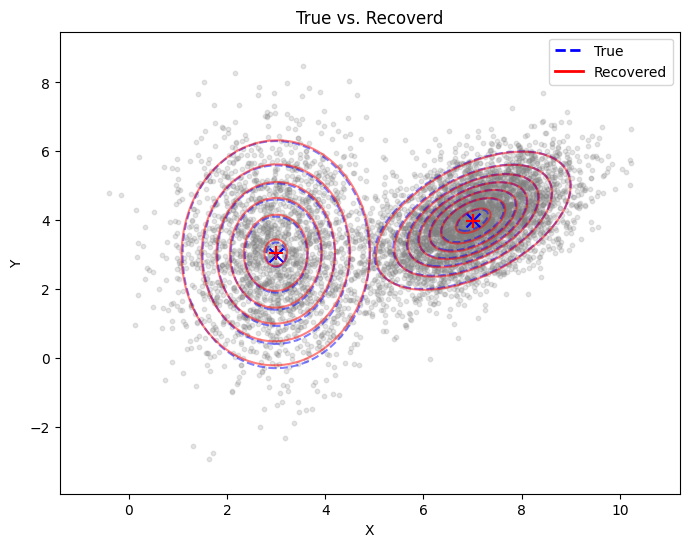

Converged after 63 iterations.

TRUE PARAMETERS:

Component 1:
  Mean: [3 3]
  Covariance:
  [[1 0]
 [0 3]]

Component 2:
  Mean: [7 4]
  Covariance:
  [[1.  0.5]
 [0.5 1. ]]

Component 3:
  Mean: [5 7]
  Covariance:
  [[1.  0.2]
 [0.2 1. ]]

RECOVERED PARAMETERS:

Component 1:
  Mean: [5.01174606 7.00148614]
  Covariance:
  [[0.97968868 0.18513852]
 [0.18513852 0.97450118]]

Component 2:
  Mean: [7.02156725 4.01546532]
  Covariance:
  [[0.99040044 0.50095345]
 [0.50095345 0.99564858]]

Component 3:
  Mean: [3.03973877 3.04862188]
  Covariance:
  [[1.02849665 0.02689357]
 [0.02689357 3.38490356]]


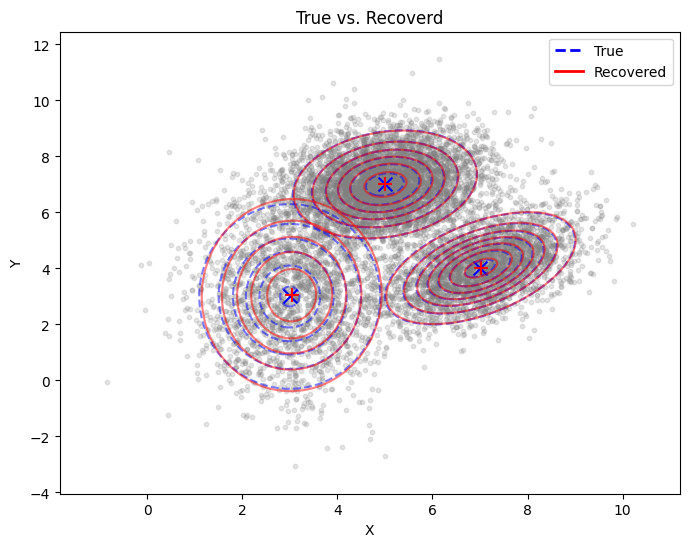

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

class GaussianMixtureEM:
    """
    Gaussian Mixture Model using Expectation-Maximization (EM) algorithm.

    Parameters:
    - n_components (int): Number of Gaussian components in the mixture.
    - max_iteration (int): Maximum number of iterations for EM algorithm.
    - tolerance (float): Convergence tolerance
    """
    def __init__(self, n_components = 2, max_iteration = 100, tolerance = 1e-6):
        self.n_components = n_components
        self.max_iteration = max_iteration
        self.tolerance = tolerance

        self.weights = None
        self.means = None
        self.covariances = None
        self.log_likelihoods = []

    def _initialize_parameters(self, X):
        """
        Initialize the model parameters.
        """
        n_samples, n_features = X.shape

        # Initialize a uniform mixing weight
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize means randomly
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        # Add small random noice
        self.means += np.random.normal(0, 0.1, size=(self.n_components, n_features))

        # Initialize covariances as identity
        self.covariances = np.array([np.eye(n_features)] * self.n_components)

    def _e_step(self, X):
        """
        Perform the E-step of the EM algorithm.
        Returns:
        - responsibilities (np.array): Array of responsibilities for each data point.
        - log_likelihood (float): Log-likelihood of the current parameters.
        """
        n_samples, _ = X.shape
        responsibilities = np.zeros((n_samples, self.n_components))

        # Calculate likelihood for each component
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])

        # Normalize to get resposibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum + 1e-8

        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(responsibilities_sum) + 1e-8)

        return responsibilities, log_likelihood

    def _m_step(self, X, responsibilities):
        """
        Perform the M-step of the EM algorithm.
        """
        n_samples, n_features = X.shape

        Nk = responsibilities.sum(axis=0)

        # Update mixing weights
        self.weights = Nk / n_samples

        # Update means
        self.means = (responsibilities.T @ X) / (Nk[:, np.newaxis] + 1e-8)

        # Update covariances
        self.covariances = np.zeros_like(self.covariances)
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k, np.newaxis] * diff
            self.covariances[k] = weighted_diff.T @ diff / (Nk[k] + 1e-8)
            # Add small regularization
            self.covariances[k] += np.eye(n_features) * 1e-6

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the data.
        """
        self._initialize_parameters(X)
        self.log_likelihoods = []
        self.prev_log_likelihood = -np.inf

        for iteration in range(self.max_iteration):
            # E-step
            responsibilities, log_likelihood = self._e_step(X)
            self.log_likelihoods.append(log_likelihood)

            # Check for convergence
            if abs(log_likelihood - self.prev_log_likelihood) < self.tolerance:
                print(f"Converged after {iteration} iterations.")
                break

            self.prev_log_likelihood = log_likelihood

            # M-step
            self._m_step(X, responsibilities)

def plot_contour(X, gmm, true_params):
    """
    Plot the Gaussian Mixture Model.
    """
    fig = plt.figure(figsize=(8, 6))

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    positions = np.dstack((xx, yy))

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, s=10, color='gray')

    # Plot true parameters
    for i in range(len(true_params['means'])):
        rv = multivariate_normal(true_params['means'][i], true_params['covariances'][i])
        contours = plt.contour(xx, yy, rv.pdf(positions), colors='blue', alpha=0.5, linestyles='dashed')
        if i == 0:
            contours.clabel(fmt='True', inline=False, fontsize=0)
            plt.plot([], [], color='blue', linestyle='dashed', linewidth=2, label='True')
        plt.scatter(true_params['means'][i][0], true_params['means'][i][1], s=100, marker='x', color='blue')

    # Plot recovered params
    for i in range(gmm.n_components):
        rv = multivariate_normal(gmm.means[i], gmm.covariances[i])
        contours = plt.contour(xx, yy, rv.pdf(positions), colors='red', alpha=0.5)
        if i == 0:
            contours.clabel(fmt='Recovered', inline=False, fontsize=0)
            plt.plot([], [], color='red', linestyle='solid', linewidth=2, label='Recovered')
        plt.scatter(gmm.means[i][0], gmm.means[i][1], s=100, marker='+', color='red')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('True vs. Recoverd')
    plt.legend()
    plt.show()

def test_gmm_em(url, n_components, true_params):
    # Fetch data
    X = pd.read_csv(url, sep="\s+", header=None).values

    # Create and fit model
    gmm = GaussianMixtureEM(n_components = n_components)
    gmm.fit(X)

    print("\n" + "="*50)
    print("TRUE PARAMETERS:")
    print("="*50)
    for i, (mean, cov) in enumerate(zip(true_params['means'], true_params['covariances'])):
        print(f"\nComponent {i+1}:")
        print(f"  Mean: {mean}")
        print(f"  Covariance:")
        print(f"  {cov}")

    # Print recovered parameters
    print("\n" + "="*50)
    print("RECOVERED PARAMETERS:")
    print("="*50)

    for i in range(gmm.n_components):
        print(f"\nComponent {i+1}:")
        print(f"  Mean: {gmm.means[i]}")
        print(f"  Covariance:")
        print(f"  {gmm.covariances[i]}")

    plot_contour(X, gmm, true_params)

def test_3gmm_em():
    # Fetch data
    X = pd.read_csv("https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/3_generative_models/HW3/3gaussian.txt", sep="\s+", header=None).values

    # Create and fit model
    gmm = GaussianMixtureEM(n_components=3, max_iteration=200, tolerance=1e-8)
    gmm.fit(X)

    # True params
    true_params = {
        'means': [np.array([3, 3]), np.array([7, 4]), np.array([5, 7])],
        'covariances': [np.array([[1, 0], [0, 3]]), np.array([[1, 0.5], [0.5, 1]]), np.array([[1, 0.2], [0.2, 1]])]
    }

    print("\n" + "="*50)
    print("TRUE PARAMETERS:")
    print("="*50)
    print("\nComponent 1:")
    print(f"  Mean: {true_params['means'][0]}")
    print(f"  Covariance:")
    print(f"  {true_params['covariances'][0]}")
    print("\nComponent 2:")
    print(f"  Mean: {true_params['means'][1]}")
    print(f"  Covariance:")
    print(f"  {true_params['covariances'][1]}")
    print("\nComponent 3:")
    print(f"  Mean: {true_params['means'][2]}")
    print(f"  Covariance:")
    print(f"  {true_params['covariances'][2]}")

    # Print recovered parameters
    print("\n" + "="*50)
    print("RECOVERED PARAMETERS:")
    print("="*50)

    for i in range(gmm.n_components):
        print(f"\nComponent {i+1}:")
        print(f"  Mean: {gmm.means[i]} .2f")
        print(f"  Covariance:")
        print(f"  {gmm.covariances[i]} .2f")

    plot_contour(X, gmm, true_params)

if __name__ == "__main__":
    test_gmm_em("https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/3_generative_models/HW3/2gaussian.txt", 2, {
        'means': [np.array([3, 3]), np.array([7, 4])],
        'covariances': [np.array([[1, 0], [0, 3]]), np.array([[1, 0.5], [0.5, 1]])]
    })
    test_gmm_em("https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/3_generative_models/HW3/3gaussian.txt", 3, {
        'means': [np.array([3, 3]), np.array([7, 4]), np.array([5, 7])],
        'covariances': [np.array([[1, 0], [0, 3]]), np.array([[1, 0.5], [0.5, 1]]), np.array([[1, 0.2], [0.2, 1]])]
    })